In [1]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# x_train.shape: 四個維度：第 1 維度為筆數、第 2, 3 維度為影像大小 32*32、第 4 維度是 RGB 三原色，所以是 3
# x_train 中有 50000 筆訓練資料，以及 x_test 中有 10000 筆的測試資料

x_train shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:
# image preprocessing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 將 features(照片影像特徵值)標準化，可以提高模型預測的準確度，並且更快收斂
x_train /= 255  # rescaling
x_test /= 255  # rescaling

In [5]:
# 將訓練資料與測試資料的label，進行Onehot encoding轉換
num_classes = 10
y_train = np.eye(num_classes, dtype='float32')[y_train[:, 0]]
y_test = np.eye(num_classes, dtype='float32')[y_test[:, 0]]

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [6]:
print(x_train.shape[1:])

(32, 32, 3)


# mixed depthwise convolution(MixConv)
![](https://i.imgur.com/KokyNcS.png)
<br>

#### X 為一個 shape 為 (h, w, c) 的 input tensor，而其中 h, w, c 所代表的分別為 height, width, channel size。
#### W 則為一個 shape 為 (k, k, c, m)的 depthwise convolutional kernel
#### k*k, c, m ，分別代表的是:
- kernel size (k)
- input channel size (c)
- channel multiplier (m)

####  g 則代表把input channel 切分成g個groups

In [14]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     Activation, Flatten, Conv2D,
                                     MaxPooling2D, Lambda, DepthwiseConv2D)

In [72]:
from tensorflow.keras.layers import (Lambda, DepthwiseConv2D)

# x: input tensor
# Group: number of Groups
def mixconv(x, Group, multiple=1):
    ch = x.shape[-1]
    ch_G = ch//Group
    x_split_lis = []
    
    for i in range(Group):
        res = Lambda(lambda x : x[:, :, :, i*ch_G:(i+1)*ch_G])(x)     
        x_split_lis.append(res)
            
    # ---
    # filter list = denote filter size, a list of integer, eg: [3,5,7...], start by 3, len = Groups
    # xi for number of group
    # fi for element in filter list. eg:(3,5,7...)
    y = []
    filter_list = range(3, 3+2*Group, 2)

    for xi, fi in zip(x_split_lis, filter_list):
        DepthwiseConv = DepthwiseConv2D(kernel_size = fi, padding='same',
                                        depth_multiplier = multiple, activation='relu')(xi)
        y.append(DepthwiseConv)
    x = tf.keras.layers.concatenate(y, axis=-1)
    return x

In [73]:
inputs = Input(shape=x_train.shape[1:])
# 建立卷積層，設定 32 個 3*3 的filters
# padding 設定為same，讓卷積運算，產生的卷積影像大小不變
# 設定ReLU為激活函數。


x = Conv2D(30, 3, padding='same', activation='relu')(inputs)
x = mixconv(x, Group=3)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = mixconv(x, Group=3, multiple = 3)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [74]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 30)   840         input_30[0][0]                   
__________________________________________________________________________________________________
lambda_69 (Lambda)              (None, 32, 32, 10)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
lambda_70 (Lambda)              (None, 32, 32, 10)   0           conv2d_28[0][0]                  
____________________________________________________________________________________________

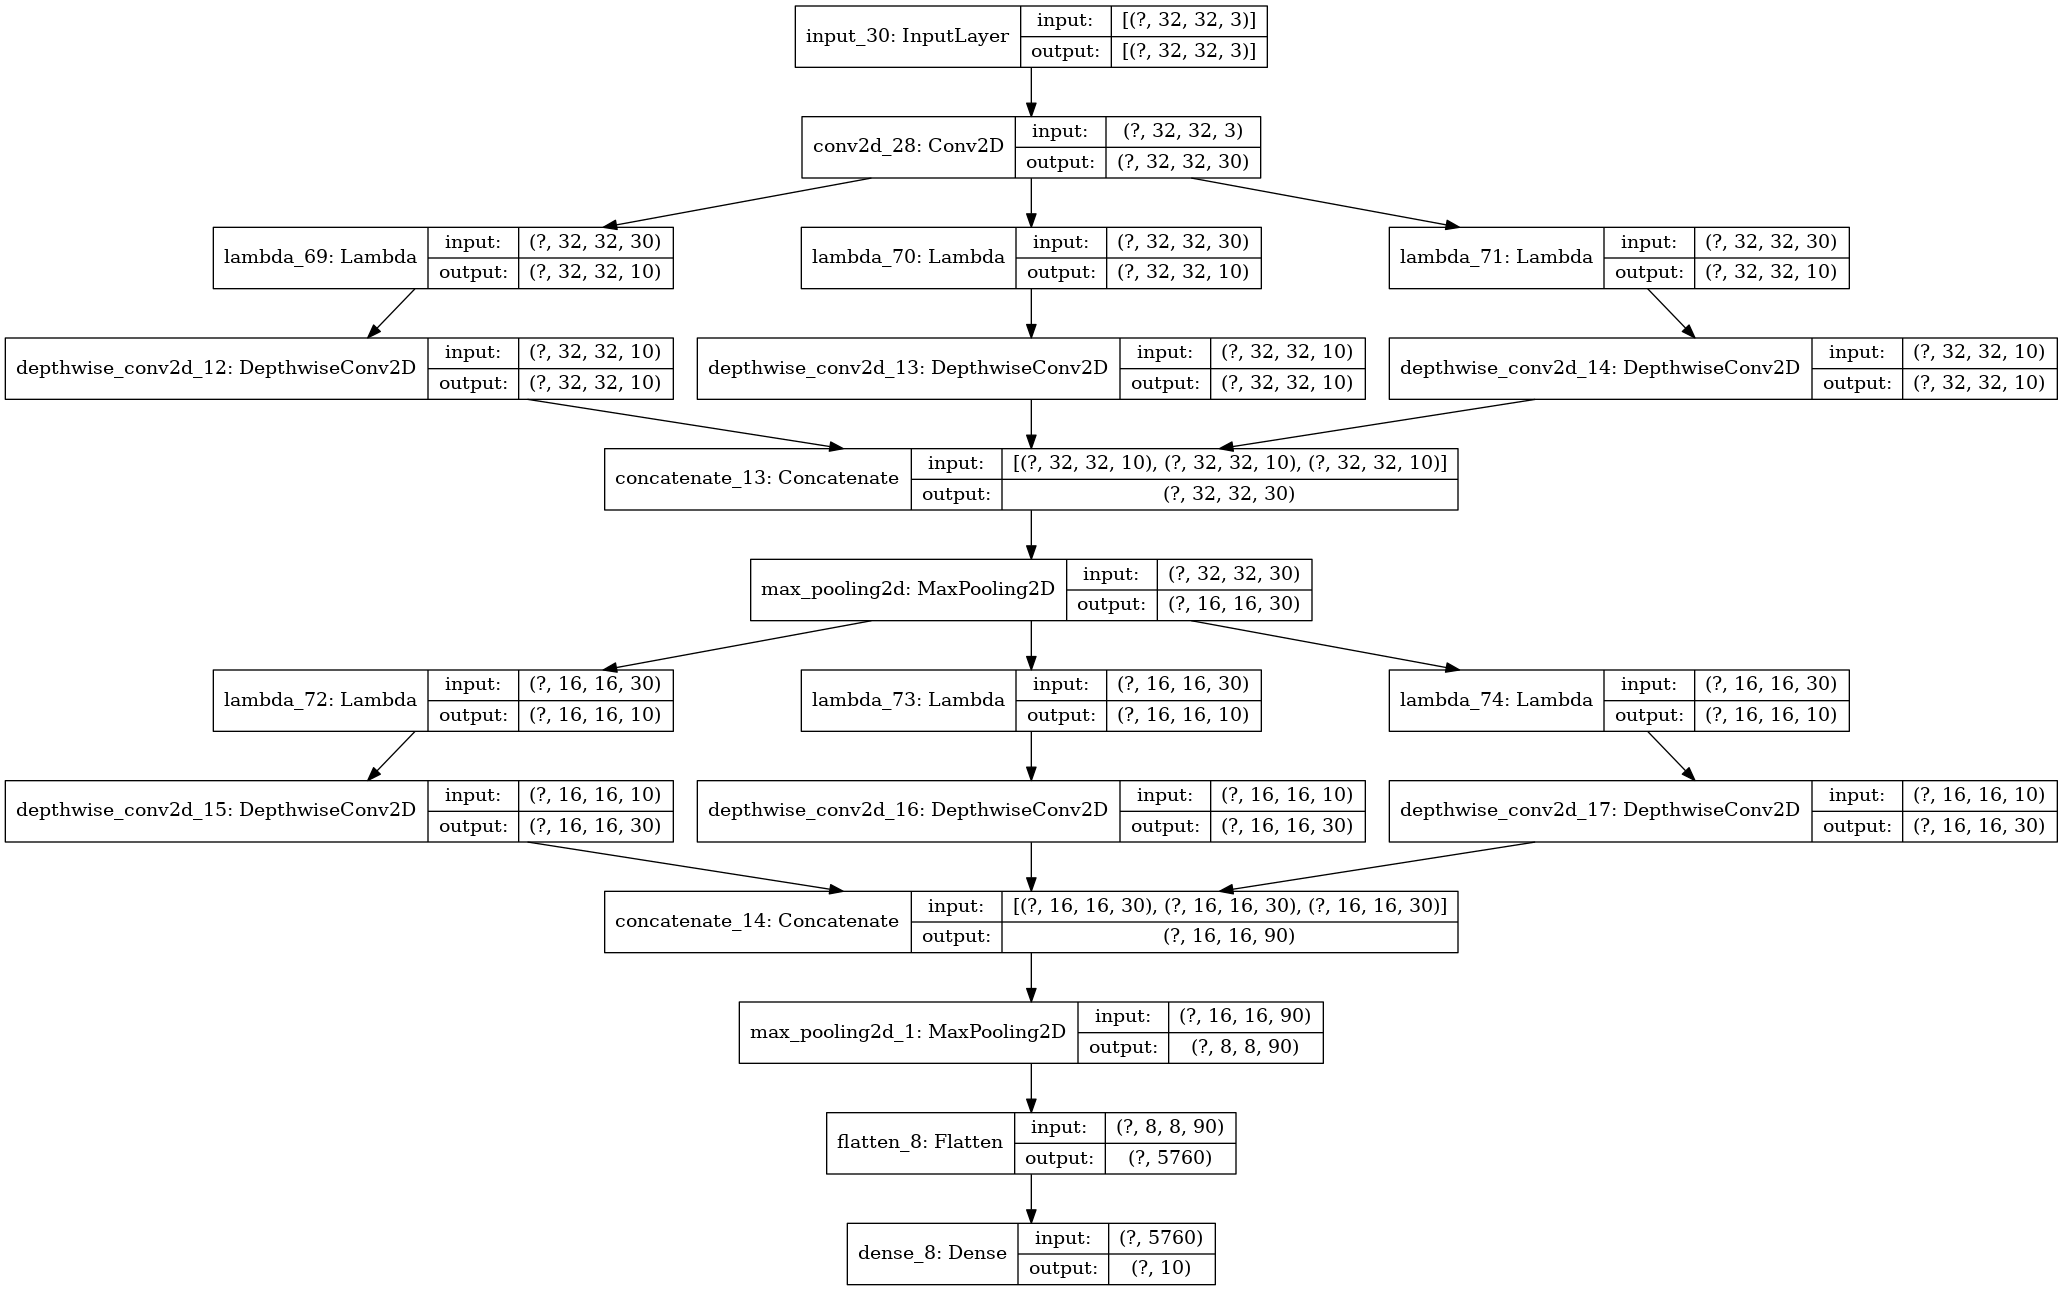

In [75]:
# model.summary()
plot_model(model, to_file='ex_Model.png', show_shapes=True)

In [76]:
# 編譯模型
# 選用 Adam 為 optimizer
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [25]:
batch_size = 512
epochs = 1
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 107s 2ms/sample - loss: 2.0176 - accuracy: 0.3262 - val_loss: 1.7624 - val_accuracy: 0.4045
